In [1]:
import torch
import math

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re

In [4]:
from pathlib import Path
import os
mypath = Path().absolute()
print(mypath)

/home/can/Documents/thai_nlp_research/BASIL/notebook


In [5]:
os.chdir("/home/can/Documents/thai_nlp_research/BASIL")

In [6]:
import sys
sys.path.append('/home/can/Documents/thai_nlp_research/BASIL')

In [7]:
import basil

In [36]:
%autoreload 2
from basil.preprocessing.prep_best_corpus import Best2010NECTEC, BestSyllable2010NECTEC
from basil.preprocessing.prep_pytorch import PytorchPrepWordLevel
from basil.models.multitasks.elmo_lstm_pretrained import LSTMTagger
from basil.evaluation.stress_test import StressEval
from basil.select_device import device
torch.device(device)

device(type='cuda', index=0)

In [9]:
best2010  = Best2010NECTEC()

Preprocessing BEST2010 corpus
Done!


In [10]:
maxx = 0
for i in range(len(best2010.test_data)):
    if len(best2010.test_data[i]) > maxx:
        maxx = len(best2010.test_data[i])
        print(i)


0
2
6
9
11
64
93
95


In [40]:
global_setup = """
from basil.preprocessing.prep_best_corpus import Best2010NECTEC
best2010  = Best2010NECTEC()
testset = best2010.test_data[95][:{n}]
"""
methods = [
    {
        'name': 'BiLSTM-ELMO',
        'setup': """
from basil.models.multitasks.elmo_lstm_pretrained import LSTMTagger
from basil.evaluation.speedeval import SpeedEvalElmo
speed_eval  = SpeedEvalElmo(LSTMTagger, "model_elmo_pretrained.p",best2010 )
        """,
        'stmt': 'speed_eval.do_pred(testset)'
    }
    , {
         'name': 'BiLSTM-U',
        'setup': """
from basil.models.multitasks.wordlvl_lstm import LSTMTagger
from basil.evaluation.speedeval import SpeedEvalU
speed_eval  = SpeedEvalU(LSTMTagger, "model_oct_word_2018best1.p",best2010 )
        """,
        'stmt': 'speed_eval.do_pred(testset)'
     },

     {
        'name': 'BiLSTM-U-BC',
        'setup': """
from basil.models.multitasks.backoff_lstm_affix_rnn_init_clean import LSTMTagger
from basil.evaluation.speedeval import SpeedEvalUBC
speed_eval  = SpeedEvalUBC(LSTMTagger, "model_affix_init_unk10_small.p",best2010 )
        """,
        'stmt': 'speed_eval.do_pred(testset)'
     },
         {
        'name': 'BiLSTM-U-BCAD',
        'setup': """
from basil.models.multitasks.backoff_lstm_affix_rnn_init_char_attn_direction import LSTMTagger
from basil.evaluation.speedeval import SpeedEvalUBCAD
speed_eval  = SpeedEvalUBCAD(LSTMTagger, "model_nov_2018best1_affix_char_attn_clipped_DIR.p",best2010 )
        """,
        'stmt': 'speed_eval.do_pred(testset)'
     }
]

In [41]:
len(best2010.test_data[95])

7561

In [42]:
# stress_eval  = StressEval(LSTMTagger, "model_elmo_pretrained.p",best2010 )
# x=stress_eval.f1_summary()

In [43]:
N = [200, 500, 1000, 2000,4000]
repeat = 5
import numpy as np
import timeit
# This cell needs to be executed twice
results = np.zeros((len(methods), len(N), repeat))
for i, method in enumerate(methods):
    for j, n in enumerate(N):
        setup = "%s \n\n%s" % (global_setup.format(n=n), method['setup'])
        data = timeit.repeat(setup=setup, stmt=method['stmt'], repeat=repeat, number=1)
        results[i, j, :] = data

Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpus
Done!
Preprocessing BEST2010 corpu

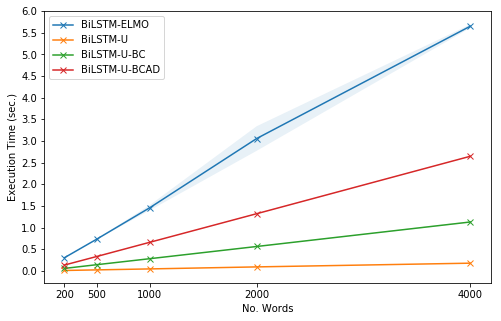

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 5))

 
for i, m in enumerate(methods):
    res = results[i, :, :]
    mean, std = np.mean(res, axis=1), np.std(res, axis=1)

    plt.plot(N, mean, label=m['name'], marker="x")
    plt.fill_between(N, mean-2*std, mean+2*std, alpha=0.1)

plt.ylabel("Execution Time (sec.)")
plt.xlabel("No. Words")
plt.yticks(np.arange(0, 6.5, 0.5))
plt.xticks(N)
plt.legend()

In [45]:
import pandas as pd
rows = []
for i, m in enumerate(methods):

  row = dict(
      method=m["name"],
  )
  for j, n in enumerate(N):
    res = results[i, j, :]
    mean, std = np.mean(res), np.std(res)
    row['Char(%d)' % n] = "%.4f±%.4f" % (mean, std)
    
  rows.append(row)
  
pd.DataFrame(rows)[['method'] + list(map(lambda n: 'Char(%d)' % n, N))]

,method,Char(200),Char(500),Char(1000),Char(2000),Char(4000)
0,BiLSTM-ELMO,0.3055±0.0036,0.7304±0.0029,1.4607±0.0305,3.0567±0.1416,5.6493±0.0199
1,BiLSTM-U,0.0100±0.0002,0.0237±0.0002,0.0462±0.0002,0.0927±0.0019,0.1787±0.0016
2,BiLSTM-U-BC,0.0578±0.0002,0.1430±0.0011,0.2825±0.0013,0.5639±0.0038,1.1294±0.0073
3,BiLSTM-U-BCAD,0.1358±0.0016,0.3317±0.0026,0.6618±0.0014,1.3210±0.0050,2.6467±0.0040
